In [1]:
# Imports
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os, sys

# Add directory to path
dir_name = os.path.dirname(os.getcwd())
sys.path.insert(1, dir_name)

# Import qlab's analysis sub-module
from qlab import analysis as qla

# Load dot env file
load_dotenv(dotenv_path=dir_name+'/qlab/.env')

# Connect to Heroku PostgreSQL
db = qla.HerokuDB(os.environ.get("HERO_URI"))
db.connect()

# Print DB tables
db.print_tables()


Connected to DB, cursor is created
Table:  ishares --- rows: 13
Table:  exchanges --- rows: 109
Table:  ft_exchanges --- rows: 7
Table:  securities --- rows: 91
Table:  etfs_data --- rows: 90
Table:  transactions --- rows: 39
Table:  prices --- rows: 89
Table:  market_segments --- rows: 89


In [2]:
pr = db.prices_table_read(assets_list=['SWDA','EIMI','EXXT','IUSA','SPYY'],portfolio=False)


In [27]:
def plotStrategy(signal, asset, asset2=None):
    if asset2 is None:
        vis=pd.concat([signal.dropna(), asset.dropna()],axis=1)
    else:
        vis=pd.concat([signal.dropna(), asset.dropna(), asset2.dropna()],axis=1)
    vis.iloc[:,0].plot(figsize=(15,8),kind='area')
    vis.iloc[:,1].plot(secondary_y=True)
    if asset2 is not None:
        vis.iloc[:,2].plot(secondary_y=True)

### Market regime based on the 2-month vol

In [5]:
from hmmlearn.hmm import GaussianHMM

Model Score: 17604.433799472856
Model Decode: (17568.81462153633, array([1, 1, 1, ..., 1, 1, 1], dtype=int32))


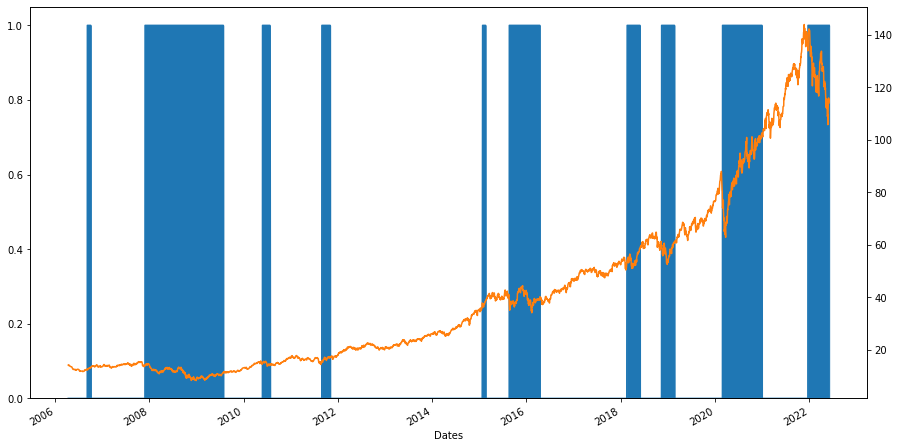

In [14]:
vol = pr.EXXT.pct_change().rolling(21*2).std().shift(1).dropna()
vol_input = np.column_stack([vol])

hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000).fit(vol_input)

print("Model Score:", hmm_model.score(vol_input))
print("Model Decode:", hmm_model.decode(vol_input))

# np.exp(10196.301755268718)
hidden_states = (hmm_model.predict(vol_input))

hs = pd.DataFrame(hidden_states, index = vol.index)
plotStrategy(hs,pr.EXXT)

### Market regime based on 3-month & 12-month returns

Model Score: 7241.6119591456845
Model Decode: (7204.945136857483, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))


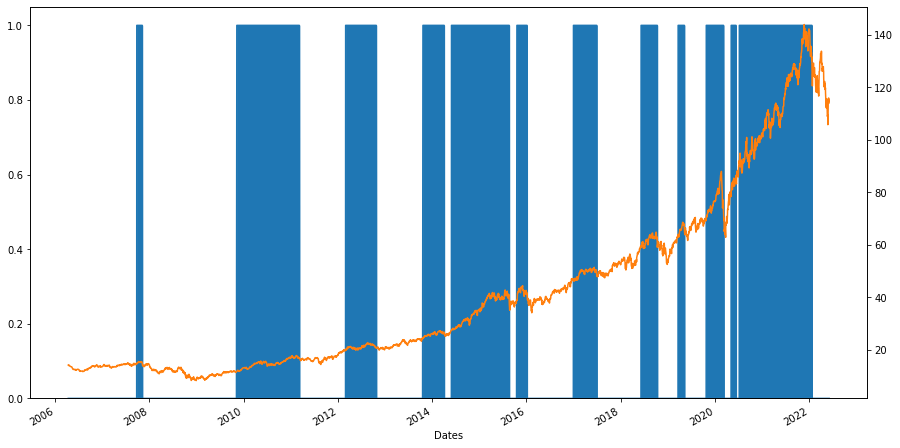

In [13]:
rt3 = pr.EXXT.pct_change(21*3)
rt12 = pr.EXXT.pct_change(21*12)
ret = pd.concat([rt3,rt12],axis=1).dropna()

ret_input = np.column_stack([ret])

hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000).fit(ret_input)

print("Model Score:", hmm_model.score(ret_input))
print("Model Decode:", hmm_model.decode(ret_input))

# np.exp(10196.301755268718)
hidden_states = (hmm_model.predict(ret_input))

hs = pd.DataFrame(hidden_states, index = ret.index)
plotStrategy(hs,pr.EXXT)

### Market regime return and vol

In [18]:
vrt = pd.concat([ret,vol],axis=1).dropna()

Model Score: 23133.266619082966
Model Decode: (23108.48738443319, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))


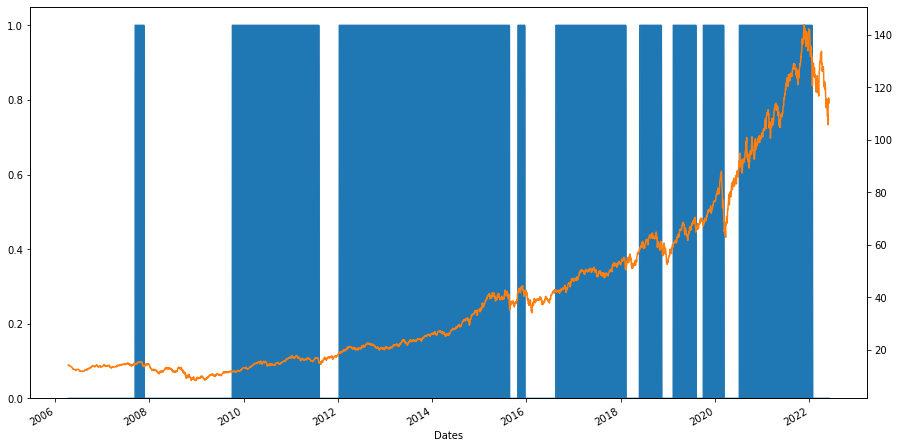

In [19]:
vrt_input = np.column_stack([vrt])

hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000).fit(vrt_input)

print("Model Score:", hmm_model.score(vrt_input))
print("Model Decode:", hmm_model.decode(vrt_input))

# np.exp(10196.301755268718)
hidden_states = (hmm_model.predict(vrt_input))

hs = pd.DataFrame(hidden_states, index = vrt.index)
plotStrategy(hs,pr.EXXT)

### Check on the regime-based strategy returns

In [20]:
def runBacktest(signal, asset):

    x = pd.concat([asset, signal],axis=1).dropna()
    x.columns = ['Asset','Signal']
    
    bt = qla.BackTest()
    
    return bt.evaluate_strategy(prices_df = x[['Asset']], signals_df = x[['Signal']], original_weights=[1])

In [22]:
br = runBacktest(hs,pr.EXXT)
br

,Asset,SIG_Signal,CNT,TRP_Asset,UNT_Asset,NET_PURCHASES,CASH,VALUE,BUY_HOLD,PCT_FEES,FLAT_FEES,TOTAL_FEES
2007-09-13,NaN,NaN,NaN,NaN,0.0,0.00,10000.0000,10000.0000,10000.00,0.00000,0.0,0.00000
2007-09-14,14.41,1.0,1.0,14.395,694.0,9990.13,9.8700,10010.4100,10010.41,9.99013,2.2,12.19013
2007-09-17,14.29,1.0,1.0,14.350,694.0,0.00,9.8700,9927.1300,9927.13,0.00000,0.0,0.00000
2007-09-18,14.36,1.0,1.0,14.325,694.0,0.00,9.8700,9975.7100,9975.71,0.00000,0.0,0.00000
2007-09-19,14.69,1.0,1.0,14.525,694.0,0.00,9.8700,10204.7300,10204.73,0.00000,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-30,115.88,0.0,0.0,115.190,0.0,0.00,51136.0015,51136.0015,80430.59,0.00000,0.0,0.00000
2022-05-31,114.62,0.0,0.0,115.250,0.0,0.00,51136.0015,51136.0015,79556.15,0.00000,0.0,0.00000
2022-06-01,114.82,0.0,0.0,114.720,0.0,0.00,51136.0015,51136.0015,79694.95,0.00000,0.0,0.00000
2022-06-02,115.04,0.0,0.0,114.930,0.0,0.00,51136.0015,51136.0015,79847.63,0.00000,0.0,0.00000


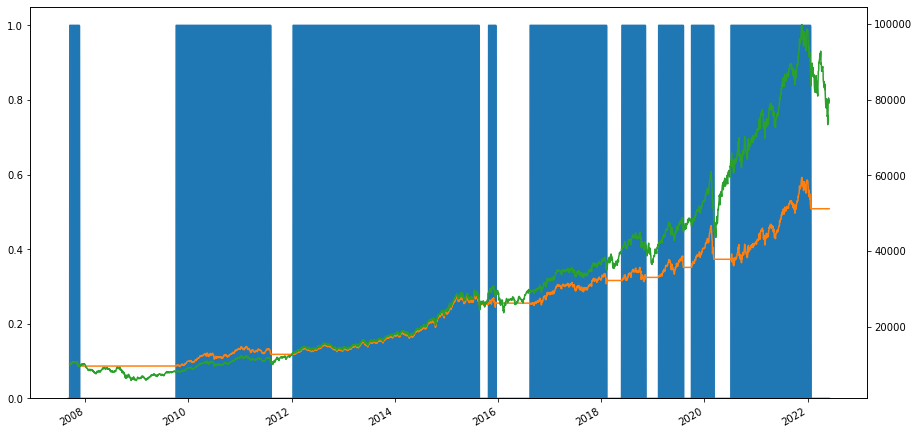

In [28]:
plotStrategy(hs,br.VALUE, br.BUY_HOLD)